# Open Food Facts: the carbon “food-print” we do not eat

## Abstract
<i>Everything we do has a carbon footprint, and our diet is no exception. From growing, farming, processing and packaging our food, energy and organic resources are consumed and released, which reflects in the emission of greenhouse gases, like CO<sub>2</sub>. In our project, we analyze the processed foods industry - its manufacturing, product composition, and sales - for the main sources of carbon emissions, using the Open Food Facts dataset. We explain the carbon footprint repartition, starting on an understanding of the products, followed by the breakdown of production countries as well as point of sales and evaluating trends in diet composition, with a special focus on nutritionally high marked products in France and the UK. 

With this study, we want to provide a better understanding of the agri-food industry, and eventually help reducing carbon emissions.</i>

In this notebook, we are performingt the above analysis on the OpenFoodFacts database, which we pre-processed using the __Open Food Facts - Cleanse Data__ notebook in the main directory.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Abstract" data-toc-modified-id="Abstract-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Abstract</a></span></li><li><span><a href="#Import-cleansed-data" data-toc-modified-id="Import-cleansed-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import cleansed data</a></span></li><li><span><a href="#Analyse-data" data-toc-modified-id="Analyse-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Analyse data</a></span><ul class="toc-item"><li><span><a href="#Production-/-manufacture-impact" data-toc-modified-id="Production-/-manufacture-impact-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Production / manufacture impact</a></span><ul class="toc-item"><li><span><a href="#Global-distribution-of-global-food-producers" data-toc-modified-id="Global-distribution-of-global-food-producers-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Global distribution of global food producers</a></span><ul class="toc-item"><li><span><a href="#Which-are-the-dominant-global-food-producers-and-manufacturers?" data-toc-modified-id="Which-are-the-dominant-global-food-producers-and-manufacturers?-3.1.1.1"><span class="toc-item-num">3.1.1.1&nbsp;&nbsp;</span>Which are the dominant global food producers and manufacturers?</a></span></li><li><span><a href="#How-is-this-distribution-impacted-when-we-consider-neutral-and-large-carbon-footprint-products?" data-toc-modified-id="How-is-this-distribution-impacted-when-we-consider-neutral-and-large-carbon-footprint-products?-3.1.1.2"><span class="toc-item-num">3.1.1.2&nbsp;&nbsp;</span>How is this distribution impacted when we consider neutral and large carbon footprint products?</a></span></li></ul></li><li><span><a href="#Case-study:-Palm-oil" data-toc-modified-id="Case-study:-Palm-oil-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>Case study: Palm oil</a></span><ul class="toc-item"><li><span><a href="#Can-we-observe-any-trend-in-the-number-of-products-including-this-oil-(assuming-a-strong-dependence-between-date-the-product-was-added-to-the-database-and-data-the-product-was-invented)?" data-toc-modified-id="Can-we-observe-any-trend-in-the-number-of-products-including-this-oil-(assuming-a-strong-dependence-between-date-the-product-was-added-to-the-database-and-data-the-product-was-invented)?-3.1.2.1"><span class="toc-item-num">3.1.2.1&nbsp;&nbsp;</span>Can we observe any trend in the number of products including this oil (assuming a strong dependence between date the product was added to the database and data the product was invented)?</a></span></li><li><span><a href="#Which-country-use-palm-oils-for-production?" data-toc-modified-id="Which-country-use-palm-oils-for-production?-3.1.2.2"><span class="toc-item-num">3.1.2.2&nbsp;&nbsp;</span>Which country use palm oils for production?</a></span></li></ul></li></ul></li><li><span><a href="#Good-nutrition-impact" data-toc-modified-id="Good-nutrition-impact-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Good nutrition impact</a></span><ul class="toc-item"><li><span><a href="#High-nutrional-products" data-toc-modified-id="High-nutrional-products-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>High-nutrional products</a></span><ul class="toc-item"><li><span><a href="#Has-there-been-a-surge-in-high-graded-Products-in-the-UK-/-France-over-the-past-years?" data-toc-modified-id="Has-there-been-a-surge-in-high-graded-Products-in-the-UK-/-France-over-the-past-years?-3.2.1.1"><span class="toc-item-num">3.2.1.1&nbsp;&nbsp;</span>Has there been a surge in high graded Products in the UK / France over the past years?</a></span></li><li><span><a href="#What-are-those-products-made-of?" data-toc-modified-id="What-are-those-products-made-of?-3.2.1.2"><span class="toc-item-num">3.2.1.2&nbsp;&nbsp;</span>What are those products made of?</a></span></li><li><span><a href="#Where-do-these-product-come-from-and-where-are-they-manufactured?" data-toc-modified-id="Where-do-these-product-come-from-and-where-are-they-manufactured?-3.2.1.3"><span class="toc-item-num">3.2.1.3&nbsp;&nbsp;</span>Where do these product come from and where are they manufactured?</a></span></li><li><span><a href="#Where-are-those-products-sold?" data-toc-modified-id="Where-are-those-products-sold?-3.2.1.4"><span class="toc-item-num">3.2.1.4&nbsp;&nbsp;</span>Where are those products sold?</a></span></li></ul></li><li><span><a href="#Carbon-footprint-of-nutrionally-high-graded-products" data-toc-modified-id="Carbon-footprint-of-nutrionally-high-graded-products-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Carbon footprint of nutrionally-high graded products</a></span><ul class="toc-item"><li><span><a href="#Are-expansive-and-polluting-products-performing-more-poorly-in-the-nutrition-mark?" data-toc-modified-id="Are-expansive-and-polluting-products-performing-more-poorly-in-the-nutrition-mark?-3.2.2.1"><span class="toc-item-num">3.2.2.1&nbsp;&nbsp;</span>Are expansive and polluting products performing more poorly in the nutrition mark?</a></span></li><li><span><a href="#Can-we-establish-a-meaningful-correlation-between-these-product-and-the-carbon-footprint--or-an-estimated-price-(using-another-dataset-or-creating-our-own-with-web-scraping)?" data-toc-modified-id="Can-we-establish-a-meaningful-correlation-between-these-product-and-the-carbon-footprint--or-an-estimated-price-(using-another-dataset-or-creating-our-own-with-web-scraping)?-3.2.2.2"><span class="toc-item-num">3.2.2.2&nbsp;&nbsp;</span>Can we establish a meaningful correlation between these product and the carbon footprint  or an estimated price (using another dataset or creating our own with web scraping)?</a></span></li><li><span><a href="#Is-there-a-general-correlation-between-high-carbon-footprint-and-price?" data-toc-modified-id="Is-there-a-general-correlation-between-high-carbon-footprint-and-price?-3.2.2.3"><span class="toc-item-num">3.2.2.3&nbsp;&nbsp;</span>Is there a general correlation between high carbon footprint and price?</a></span></li></ul></li><li><span><a href="#Plot-distribution-of-availability-of-products-in-countries" data-toc-modified-id="Plot-distribution-of-availability-of-products-in-countries-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Plot distribution of availability of products in countries</a></span></li></ul></li></ul></li></ul></div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
from scipy import stats
import seaborn as sns
from datetime import datetime

import json
import pickle

import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
%load_ext autoreload
%autoreload 2
    
import libs.exploring as explore
import libs.visualising as visualize
import libs.cleansing as cleanse

## Import cleansed data

In [2]:
# Import data
open_food_facts_csv_file = "./data/openfoodfacts_clean.csv"

food_facts_pd = pd.read_csv(open_food_facts_csv_file,
                            delimiter="\t")

In [23]:
# Change column data types
food_facts_pd['carbon-footprint_100g'] = food_facts_pd['carbon-footprint_100g'].apply(pd.to_numeric, args=('coerce',))
food_facts_pd['energy_100g'] = food_facts_pd['energy_100g'].apply(pd.to_numeric, args=('coerce',))
food_facts_pd['price_per_100g'] = food_facts_pd['price_per_100g'].apply(pd.to_numeric, args=('coerce',))
food_facts_pd['created_datetime'] = food_facts_pd['created_datetime'].apply(pd.to_datetime, args=('coerce',))

# Replace missing values
food_facts_pd.origins_cleaned= food_facts_pd.origins_cleaned.fillna("['Unknown']")
food_facts_pd.manufacturing_place_cleaned= food_facts_pd.manufacturing_place_cleaned.fillna("['Unknown']")
food_facts_pd.purchase_places_cleaned= food_facts_pd.purchase_places_cleaned.fillna("['Unknown']")
# food_facts_pd = food_facts_pd.fillna('')

# List tags
food_facts_pd.origins_cleaned = \
    food_facts_pd.origins_cleaned.apply(lambda l: cleanse.read(l))

food_facts_pd.manufacturing_place_cleaned = \
    food_facts_pd.manufacturing_place_cleaned.apply(lambda l: cleanse.read(l))

food_facts_pd.purchase_places_cleaned = \
                        food_facts_pd.purchase_places_cleaned.apply(lambda l: cleanse.read(l))

In [4]:
food_facts_pd.head(5)

,Unnamed: 0,code,created_t,created_datetime,product_name,quantity,packaging,brands,categories_en,labels_en,...,main_category,energy_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,origins_cleaned,manufacturing_place_cleaned,purchase_places_cleaned,price_per_100g,store_currency
0,0,0000000274722,1514659309,2017-12-30 18:41:49,Blanquette de Volaille et son Riz,,"carton,plastique",Comme J’aime,"Meals,Meat-based products,Meals with meat,Poul...","['Viande Française', 'Made In France']",...,meals,450,,0,0,[Unknown],[France],[France],,
1,1,0000000394710,1484497370,2017-01-15 16:22:50,Danoises à la cannelle roulées,1.150 kg,Frais,Kirkland Signature,"Sugary snacks,Biscuits and cakes,Pastries",[''],...,sugary-snacks,1520,,,,[France],[France],[France],,
2,2,0000001071894,1409411252,2014-08-30 15:07:32,Flute,,"Paper,plastic film",Waitrose,"Plant-based foods and beverages,Plant-based fo...",[''],...,plant-based-foods-and-beverages,,,,,[Canada],[Unknown],[Canada],,
3,3,0000001938067,1484501528,2017-01-15 17:32:08,Chaussons tressés aux pommes,1.200 kg,Frais,Kirkland Signature,"Sugary snacks,Biscuits and cakes,Pastries",[''],...,sugary-snacks,1090,,9,9,[France],[United Kingdom],[United Kingdom],,
4,4,0000004302544,1488464896,2017-03-02 14:28:16,Pain Burger Artisan,1.008 kg / 12 pain,"Frais,plastique",Kirkland Signature,boulange,[''],...,boulange,1160,,1,1,[Canada],[Unknown],[Canada],,


## Analyse data

### Production / manufacture impact

#### Global distribution of global food producers

In [ ]:
countries_label = pd.read_csv("./data/country_lookup.csv")[['name', 'cca3']]                                          

##### Which are the dominant global food producers and manufacturers?

- From where are those products originating?

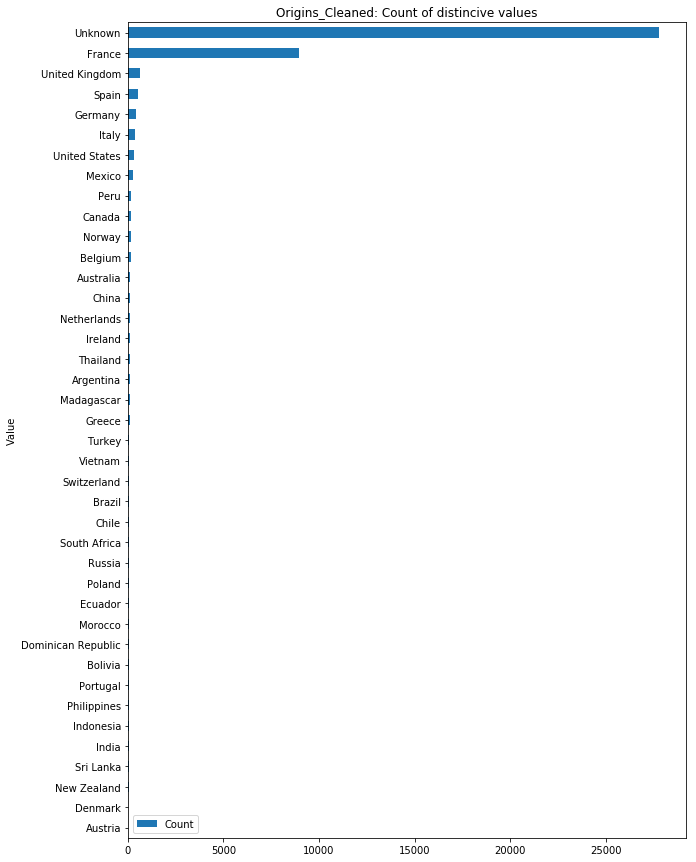

In [5]:
values_set, values_count_origins = visualize.plot_occurences_of_distinct_values(food_facts_pd, 'origins_cleaned')

In [ ]:
values_count_origins = pd.DataFrame.from_dict(values_count_origins, orient='index', columns=['Count']).reset_index().rename(index=str, columns={"index": "Country", "Count": "Count"})
values_count_origins = values_count_origins[values_count_origins.Country != "Unknown"]
values_count_origins['cca3'] = values_count_origins.Country.apply(lambda l: visualize.search_cca3(l, countries_label))
values_count_origins['Count'] = values_count_origins.Count.apply(lambda l: np.log(l))
values_count_origins= values_count_origins[['cca3', 'Count']]


In [ ]:
country_geo = './data/world-countries.json'

map = folium.Map(location=[0, 0], tiles='Mapbox Bright', zoom_start=1.5)

# choropleth maps bind Pandas Data Frames and json geometries.
map.choropleth(geo_data=country_geo,
               data=values_count_origins,
               columns=['cca3', 'Count'],
               fill_color='YlGnBu', 
               key_on='feature.id',
               threshold_scale=[0, 2, 4,8,11, 12],
               legend_name='Origin Country : logscale of entries (base 10) [Countries in purple are empty]',
               fill_opacity=0.7, 
               line_opacity=0.2,
               )
map

Note that country in purple are wrongfully assigned the maximal value (they are in fact not assigned any value) due to folium. 

- Where are those products manufactured?

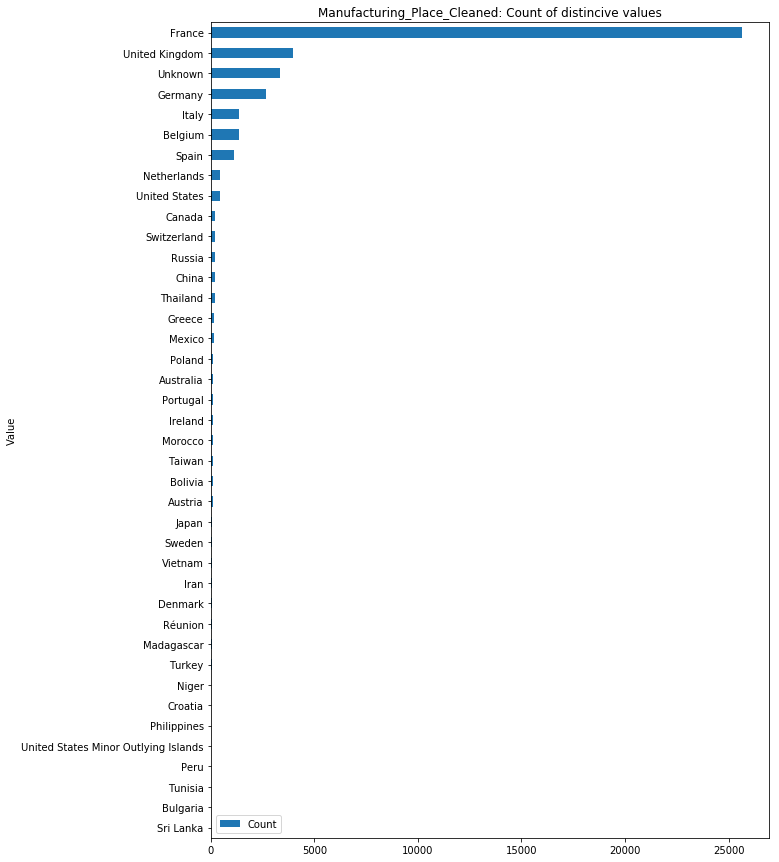

In [6]:
values_set, values_count_manufacturing = visualize.plot_occurences_of_distinct_values(food_facts_pd, 'manufacturing_place_cleaned')

In [ ]:
values_count_manufacturing = pd.DataFrame.from_dict(values_count_manufacturing, orient='index', columns=['Count']).reset_index().rename(index=str, columns={"index": "Country", "Count": "Count"})
values_count_manufacturing = values_count_manufacturing[values_count_manufacturing.Country != "Unknown"]
values_count_manufacturing['cca3'] = values_count_manufacturing.Country.apply(lambda l: visualize.search_cca3(l, countries_label))
values_count_manufacturing['Count'] = values_count_manufacturing.Count.apply(lambda l: np.log(l))
values_count_manufacturing= values_count_manufacturing[['cca3', 'Count']]


In [ ]:
country_geo = './data/world-countries.json'

map = folium.Map(location=[0, 0], tiles='Mapbox Bright', zoom_start=1.5)

# choropleth maps bind Pandas Data Frames and json geometries.
map.choropleth(geo_data=country_geo,
               data=values_count_manufacturing,
               columns=['cca3', 'Count'],
               fill_color='YlGnBu', 
               key_on='feature.id',
               threshold_scale=[0, 2, 4,8,11, 12],
               legend_name='Manufacturing : logscale of entries (base 10) [Countries in purple are empty]',
               fill_opacity=0.7, 
               line_opacity=0.2,
               )
map

- Where are those products bought?

In [ ]:
values_set, values_count_purchase = visualize.plot_occurences_of_distinct_values(food_facts_pd, 'purchase_places_cleaned')

In [ ]:
values_count_purchase = pd.DataFrame.from_dict(values_count_purchase, orient='index', columns=['Count']).reset_index().rename(index=str, columns={"index": "Country", "Count": "Count"})
values_count_purchase = values_count_purchase[values_count_purchase.Country != "Unknown"]
values_count_purchase['cca3'] = values_count_purchase.Country.apply(lambda l: visualize.search_cca3(l, countries_label))
values_count_purchase['Count'] = values_count_purchase.Count.apply(lambda l: np.log(l))
values_count_purchase= values_count_purchase[['cca3', 'Count']]


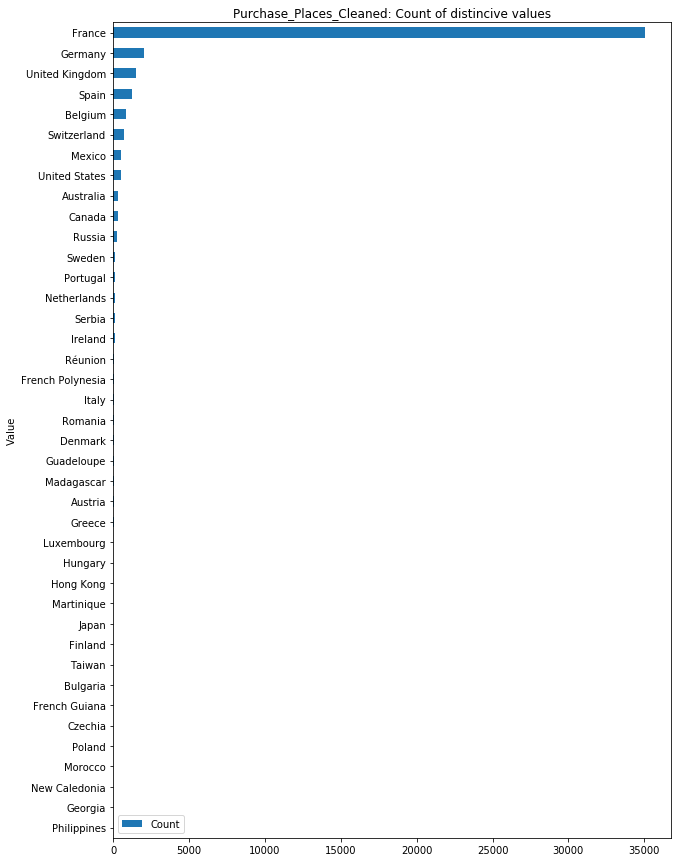

In [7]:
country_geo = './data/world-countries.json'

map = folium.Map(location=[0, 0], tiles='Mapbox Bright', zoom_start=1.5)

# choropleth maps bind Pandas Data Frames and json geometries.
map.choropleth(geo_data=country_geo,
               data=values_count_purchase,
               columns=['cca3', 'Count'],
               fill_color='YlGnBu', 
               key_on='feature.id',
               threshold_scale=[0, 2, 4,8,11, 12],
               legend_name='Purchasing : logscale of entries (base 10) [Countries in purple are empty]',
               fill_opacity=0.7, 
               line_opacity=0.2,
               )
map

In conclusion, we note that we mainly have data for "western" countries. We mostly lack information for country in Africa and the centre of Asia. 

##### How is this distribution impacted when we consider neutral and large carbon footprint products? 

In [8]:
# dataset carbon footprint coming from Eaternity
# This will be assess in future version of this project

#### Case study: Palm oil

##### Can we observe any trend in the number of products including this oil (assuming a strong dependence between date the product was added to the database and data the product was invented)?

In [9]:
#extracting products with palm oil 
palm_oil_pd = food_facts_pd[food_facts_pd.ingredients_text.str.contains("palm").fillna(value=False)]

In [10]:
print('{0} % of the products in the dataset contain palm oil'.format(palm_oil_pd.shape[0]/food_facts_pd.shape[0]))

0.050875607551962486 % of the products in the dataset contain palm oil


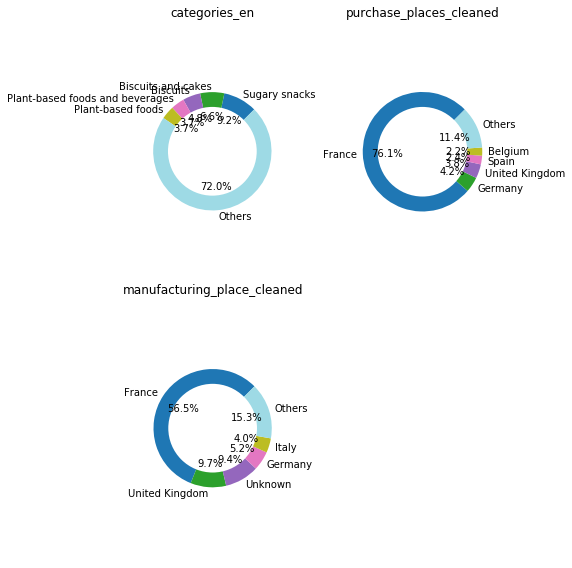

In [11]:
visualize.plot_column_composition(palm_oil_pd, 
                                  ['categories_en', 
                                   'purchase_places_cleaned', 
                                   'manufacturing_place_cleaned']
                                 )

In [12]:
#palm_oil_pd.groupby('main_category')

##### Which country use palm oils for production?

In [13]:
a = palm_oil_pd.origins_cleaned.groupby(palm_oil_pd.origins_cleaned).sum

### Good nutrition impact

#### High-nutrional products

##### Has there been a surge in high graded Products in the UK / France over the past years?

In [18]:
nutrition_fr = food_facts_pd[['created_datetime',
                              'nutrition-score-fr_100g', 
                              'main_category', 
                              'origins_cleaned', 
                              'purchase_places_cleaned', 
                              'manufacturing_place_cleaned']
                            ]
nutrition_fr = nutrition_fr[nutrition_fr['nutrition-score-fr_100g'] != '']
#nutrition_over_time = nutrition_fr.sort_values(by = 'created_datetime')

##### What are those products made of?
What is the composition? Do they contain many additives?  Where are these products sold? 

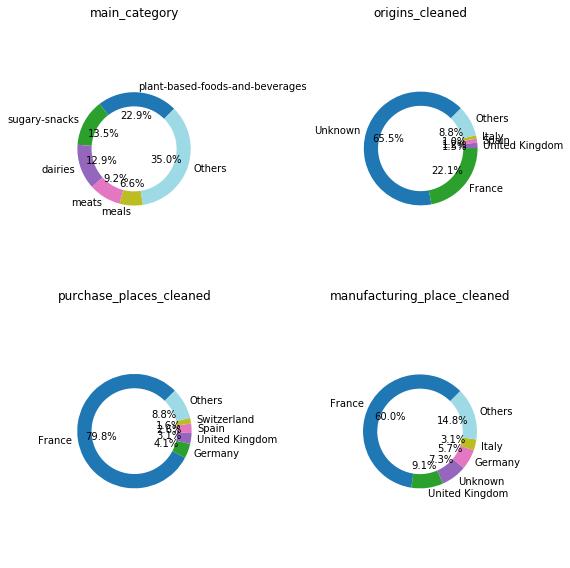

In [19]:
visualize.plot_column_composition(nutrition_fr, 
                                  ['main_category', 
                                   'origins_cleaned', 
                                   'purchase_places_cleaned', 
                                   'manufacturing_place_cleaned']
                                 )

##### Where do these product come from and where are they manufactured?

##### Where are those products sold?

#### Carbon footprint of nutrionally-high graded products
Common sense would suggest most nutritionally-high graded products are organic (plant, fruit, vegetables, …) and are therefore not manufactured, thus having a small footprint.

In [26]:
carbon_footprints = food_facts_pd[food_facts_pd['carbon-footprint_100g'].notna()]
carbon_footprints

,Unnamed: 0,code,created_t,created_datetime,product_name,quantity,packaging,brands,categories_en,labels_en,...,main_category,energy_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,origins_cleaned,manufacturing_place_cleaned,purchase_places_cleaned,price_per_100g,store_currency
1778,1778,0819377000120,1537556615,2018-09-21 19:03:35,châtaignes pelées et rôties cesares,150 g,conserve,cesares,"Plant-based foods and beverages,Plant-based fo...",['Carbon footprint'],...,plant-based-foods-and-beverages,1000.0,300.00,0,0,[Unknown],[France],[France],0.635,EURO
2619,2619,2000000072530,1533075976,2018-07-31 22:26:16,Nestle Aguitas Manzana,300ml,botella de plastico,nestle,agua-embotellada,"['Ecoce', 'Carbon footprint']",...,agua-embotellada,41.3,0.00,0,0,[United Kingdom],[Unknown],[France],NaN,
2633,2633,2000000074609,1536152379,2018-09-05 12:59:39,Terrine de Chevreuil,180 gr,"Conserve,bocal,Verre,180gr","AJM,SARL AJM","Meat-based products,Terrine,Terrines de chevre...","['Carbon footprint', 'Fait-Maison', 'Carbon fo...",...,meat-based-products,1653.0,0.05,21,21,[France],[France],[France],NaN,
2639,2639,2000000074660,1536214006,2018-09-06 06:06:46,TERRINE AUX CHÂTAIGNES,180 gr,"Conserve,Bocal,Verre,Verrine,180gr","AJM,Sarl AJM","Plant-based foods and beverages,Plant-based fo...","['Fait-Maison', 'Carbon footprint']",...,plant-based-foods-and-beverages,1653.0,0.05,21,21,[Unknown],[Sweden],[France],NaN,
2670,2670,2000000205397,1528475275,2018-06-08 16:27:55,Baguette Millavoise 6 céréales,250 g,plastique,,"Plant-based foods and beverages,Plant-based fo...","['Carbon footprint', 'Carbon footprint']",...,plant-based-foods-and-beverages,1230.0,0.00,-2,-2,[Unknown],[Belgium],[France],NaN,
4728,4728,22016119,1484132933,2017-01-11 11:08:53,"Migros, M Classic",180 g,"Couvercle alu,Gobelet plastique,Banderole carton","Migros,M Classic","Dairies,Fermented foods,Fermented milk product...","['Carbon footprint', 'Carbon footprint']",...,dairies,400.0,199.70,4,4,[Unknown],[France],[France],NaN,
4729,4729,22016140,1483551803,2017-01-04 17:43:23,Yogurt Mandarine,180g,"Couvercle alu,Gobelet plastique,Banderole carton","Migros,M Classic","Dairies,Fermented foods,Fermented milk product...","['Carbon footprint', 'Carbon footprint']",...,dairies,400.0,196.50,4,4,[Unknown],[France],[France],0.600,CHF
4731,4731,22016256,1393184903,2014-02-23 19:48:23,Yogourt Rhubarbe/Vanille,180 g,"Carton,Plastique","Migros,M-Classic,Elsa","Dairies,Fermented foods,Fermented milk product...","['Carbon footprint', 'Carbon footprint']",...,dairies,397.0,193.40,4,4,[France],[France],[France],0.600,CHF
4800,4800,22139320,1408623595,2014-08-21 12:19:55,Ice Coffee,250 ml,Brique carton,"Migros,M-Classic,Elsa","Beverages,Dairies,Dairy drinks,Sugared beverages",['Carbon footprint'],...,beverages,251.0,136.00,1,1,[Unknown],[Italy],[United Kingdom],1.180,CHF
5562,5562,26038490,1503828865,2017-08-27 10:14:25,Cacahuètes grillées à sec,150 g,sachet,Trader Joe's,aliments-pour-aperitifs,[''],...,aliments-pour-aperitifs,2489.0,0.00,20,20,[Italy],[Italy],[Switzerland],0.453,CHF


First, we should sensibilize for the data that we are dealing with. Therefore we visualize the origin and composition of the products.

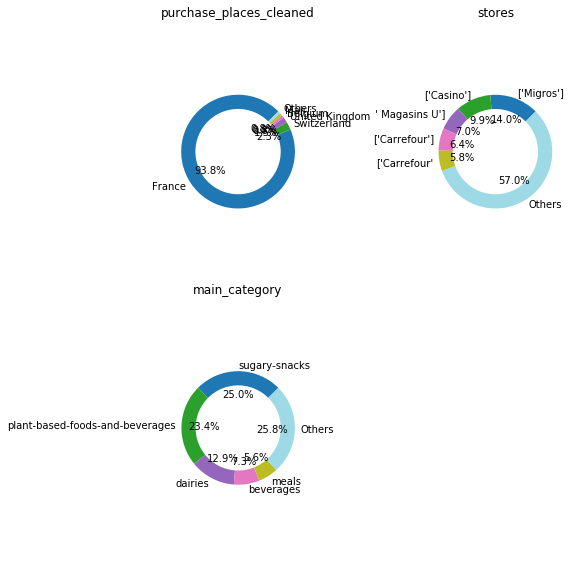

In [21]:
visualize.plot_column_composition(carbon_footprints, 
                                  columns=['purchase_places_cleaned', 
                                           'stores', 
                                           'main_category'])

##### Are expansive and polluting products performing more poorly in the nutrition mark?

##### Can we establish a meaningful correlation between these product and the carbon footprint  or an estimated price (using another dataset or creating our own with web scraping)? 

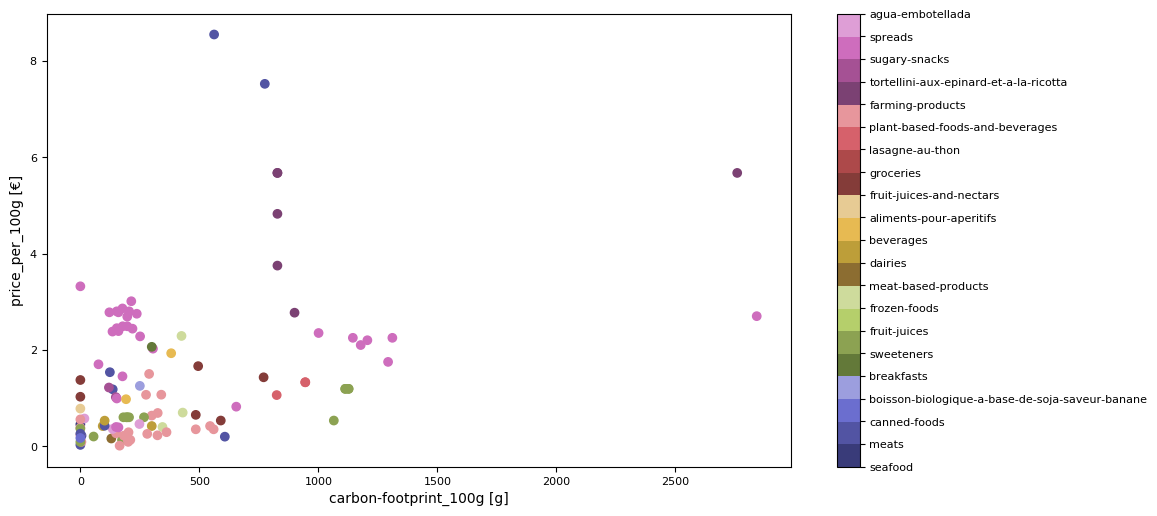

In [27]:
# Food calories over carbon-foot print
visualize.plot_cluster_by_tags(df=carbon_footprints,
                               plot2D_features = ["carbon-footprint_100g", "price_per_100g"],
                               cluster="main_category")

##### Is there a general correlation between high carbon footprint and price? 

#### Plot distribution of availability of products in countries

In [ ]:
# Find all distinct countries
countries_set = set()
for index, row in food_facts_pd.iterrows():
    for country in row.countries_en:
        countries_set.add(country)

# Count the number of time each country appear in the dataframe
country_count = dict()
for country in list(countries_set):
    country_count[country] = food_facts_pd.countries_en.apply({country}.issubset).sum()

In [ ]:
country_count_pd = pd.DataFrame(list(country_count.items()), columns=['Country', 'Value'])
country_count_pd['Country'] = country_count_pd['Country'].str.upper()
country_count_pd

In [ ]:
import folium

## Country coordinates for plotting
country_geo = './data/world-countries.json'

map = folium.Map(location=[0, 0], tiles='Mapbox Bright', zoom_start=1.5)

# choropleth maps bind Pandas Data Frames and json geometries.
map.choropleth(geo_data=country_geo,
               data=country_count_pd,
               columns=['Country', 'Value'],
               fill_color='YlGnBu', 
               key_on='feature.id',
               fill_opacity=0.7, 
               line_opacity=0.2,
               )
map